In [1]:
from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Tuple, List, Optional
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
import os
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_community.graphs import Neo4jGraph
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase

In [3]:
from yfiles_jupyter_graphs import GraphWidget
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_core.runnables import ConfigurableField, RunnableParallel, RunnablePassthrough

### Loading a sample Wiki Article

In [4]:
# Read the wikipedia article
raw_documents = WikipediaLoader(query="Elizabeth I",load_max_docs=2).load()
# Define chunking strategy
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
documents = text_splitter.split_documents(raw_documents[:3])

C:\Users\Sayantan\anaconda3\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Sayantan\anaconda3\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [8]:
len(documents)

2

In [5]:
graph = Neo4jGraph()

Now it's time to construct a graph based on the retrieved documents. For this purpose, we have implemented an ```LLMGraphTransformermodule``` that significantly simplifies constructing and storing a knowledge graph in a graph database.

In [6]:
llm=llm = AzureChatOpenAI(temperature = 0, model = "gpt-35-turbo-16k") # gpt-4-0125-preview occasionally has issues
llm_transformer = LLMGraphTransformer(llm=llm)

graph_documents = llm_transformer.convert_to_graph_documents(documents)
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

In [7]:
# directly show the graph resulting from the given Cypher query
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 50"

def showGraph(cypher: str = default_cypher):
    # create a neo4j session to run queries
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

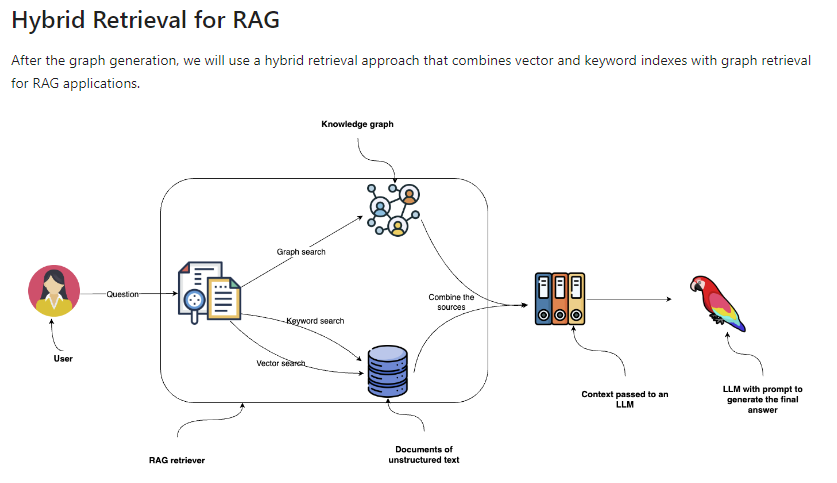

The diagram illustrates a retrieval process beginning with a user posing a question, which is then directed to an RAG retriever. This retriever employs keyword and vector searches to search through unstructured text data and combines it with the information it collects from the knowledge graph. Since Neo4j features both keyword and vector indexes, you can implement all three retrieval options with a single database system. The collected data from these sources is fed into an LLM to generate and deliver the final answer.

In [9]:
from langchain_openai import AzureOpenAIEmbeddings
embed_model = AzureOpenAIEmbeddings(azure_deployment="text-embedding-ada-002")

In [10]:
vector_index = Neo4jVector.from_existing_graph(
    embed_model,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

In [14]:
result = vector_index.similarity_search("Elizabeth I?", k=1)
result

[Document(page_content='\ntext: Elizabeth I (7 September 1533 – 24 March 1603) was Queen of England and Ireland from 17 November 1558 until her death in 1603. She was the last monarch of the House of Tudor.\nElizabeth was the only surviving child of Henry VIII and his second wife, Anne Boleyn. When Elizabeth was two years old, her parents\' marriage was annulled, her mother was executed, and Elizabeth was declared illegitimate. Henry restored her to the line of succession when she was 10, via the Third Succession Act 1543. After Henry\'s death in 1547, Elizabeth\'s younger half-brother Edward VI ruled until his own death in 1553, bequeathing the crown to a Protestant cousin, Lady Jane Grey, and ignoring the claims of his two half-sisters, the Catholic Mary and the younger Elizabeth, in spite of statutes to the contrary. Edward\'s will was set aside within weeks of his death and Mary became queen, deposing and executing Jane. During Mary\'s reign, Elizabeth was imprisoned for nearly a y

In [15]:
from langchain.chains import GraphCypherQAChain

chain = GraphCypherQAChain.from_llm(graph=graph, llm=llm, verbose=True)
response = chain.invoke({"query": "Who is Elizabeth I?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (elizabeth:Person {name: 'Elizabeth I'})-[:RULER_OF]->(england:Country)
RETURN elizabeth, england
Full Context:
[]

> Finished chain.


{'query': 'Who is Elizabeth I?', 'result': "I don't know the answer."}

In [17]:
chain.invoke({"query": "Where was Amelia Earhart born?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:BORN_IN]->(l:Location)
WHERE p.name = 'Amelia Earhart'
RETURN l.name
Full Context:
[]

> Finished chain.


{'query': 'Where was Amelia Earhart born?',
 'result': "I don't know the answer."}

## Custom Chaining

In [20]:
# Retriever

graph.query(
    "CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

# Extract entities from text
class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or business entities that "
        "appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

In [23]:
entity_chain.invoke({"question": "Where was Amelia Earhart born?"})

Entities(names=['Amelia Earhart'])

In [21]:
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

# Fulltext index query
def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of entities mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node,score
            CALL {
              WITH node
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
              UNION ALL
              WITH node
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result

In [22]:
print(structured_retriever("Who is Elizabeth I?"))

Elizabeth I - RULED -> England
Elizabeth I - RULED -> Ireland
Elizabeth I - BELONGED_TO -> House Of Tudor
Elizabeth I - CHILD_OF -> Henry Viii
Elizabeth I - CHILD_OF -> Anne Boleyn
Elizabeth I - RESTORED_TO_LINE_OF_SUCCESSION_BY -> Third Succession Act 1543
Elizabeth I - HALF-SISTER_OF -> Edward Vi
Elizabeth I - IGNORED_THE_CLAIMS_OF -> Lady Jane Grey
Elizabeth I - IGNORED_THE_CLAIMS_OF -> Mary
Elizabeth I - SUPPORTED -> Protestant
Elizabeth I - TOLERANT_TOWARDS -> Catholic
Elizabeth I - DEPENDED_HEAVILY_ON -> William Cecil
Elizabeth I - CREATED -> Baron Burghley
Elizabeth I - ESTABLISHED -> Church Of England
Elizabeth I - REFERRED_TO_AS -> Virgin Queen
Elizabeth I - SUCCEEDED_BY -> James Vi Of Scotland
Elizabeth I - COUSIN_OF -> Mary, Queen Of Scots
Elizabeth I - MORE_MODERATE_THAN -> Government
Elizabeth I - HAD_AS_MOTTO -> Video Et Taceo
Elizabeth I - RELATIVELY_TOLERANT_TOWARDS -> Religion
Elizabeth I - RUN_BY -> Sir Francis Walsingham
Elizabeth I - MANEUVERED_BETWEEN -> France
Eli

In [24]:
def retriever(question: str):
    print(f"Search query: {question}")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Document ". join(unstructured_data)}
    """
    return final_data

In [25]:
print(retriever("Who is Elizabeth I?"))

Search query: Who is Elizabeth I?
Structured data:
Elizabeth I - RULED -> England
Elizabeth I - RULED -> Ireland
Elizabeth I - BELONGED_TO -> House Of Tudor
Elizabeth I - CHILD_OF -> Henry Viii
Elizabeth I - CHILD_OF -> Anne Boleyn
Elizabeth I - RESTORED_TO_LINE_OF_SUCCESSION_BY -> Third Succession Act 1543
Elizabeth I - HALF-SISTER_OF -> Edward Vi
Elizabeth I - IGNORED_THE_CLAIMS_OF -> Lady Jane Grey
Elizabeth I - IGNORED_THE_CLAIMS_OF -> Mary
Elizabeth I - SUPPORTED -> Protestant
Elizabeth I - TOLERANT_TOWARDS -> Catholic
Elizabeth I - DEPENDED_HEAVILY_ON -> William Cecil
Elizabeth I - CREATED -> Baron Burghley
Elizabeth I - ESTABLISHED -> Church Of England
Elizabeth I - REFERRED_TO_AS -> Virgin Queen
Elizabeth I - SUCCEEDED_BY -> James Vi Of Scotland
Elizabeth I - COUSIN_OF -> Mary, Queen Of Scots
Elizabeth I - MORE_MODERATE_THAN -> Government
Elizabeth I - HAD_AS_MOTTO -> Video Et Taceo
Elizabeth I - RELATIVELY_TOLERANT_TOWARDS -> Religion
Elizabeth I - RUN_BY -> Sir Francis Walsin

In [27]:
# Condense a chat history and follow-up question into a standalone question
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""  # noqa: E501
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

_search_query = RunnableBranch(
    # If input includes chat_history, we condense it with the follow-up question
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name="HasChatHistoryCheck"
        ),  # Condense follow-up question and chat into a standalone_question
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT
        | llm
        | StrOutputParser(),
    ),
    # Else, we have no chat history, so just pass through the question
    RunnableLambda(lambda x : x["question"]),
)

In [28]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

In [29]:
chain.invoke({"question": "Which house did Elizabeth I belong to?"})

Search query: Which house did Elizabeth I belong to?


'Elizabeth I belonged to the House of Tudor.'

In [30]:
chain.invoke(
    {
        "question": "When was she born?",
        "chat_history": [("Which house did Elizabeth I belong to?", "House Of Tudor")],
    }
)

Search query: When was Elizabeth I born?


'Elizabeth I was born on September 7, 1533.'